In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras scikit-learn librosa pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.5 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/50
208/208 [==============================] - 89s 417ms/step - loss: 1.8020 - accuracy: 0.3071 - val_loss: 1.4180 - val_accuracy: 0.4704 - lr: 0.0010
Epoch 2/50
208/208 [==============================] - 82s 395ms/step - loss: 1.1687 - accuracy: 0.5724 - val_loss: 0.9575 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 3/50
208/208 [==============================] - 82s 394ms/step - loss: 0.8116 - accuracy: 0.7234 - val_loss: 0.7610 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 4/50
208/208 [==============================] - 82s 394ms/step - loss: 0.6068 - accuracy: 0.7980 - val_loss: 0.5908 - val_accuracy: 0.8039 - lr: 0.0010
Epoch 5/50
208/208 [==============================] - 81s 392ms/step - loss: 0.4825 - accuracy: 0.8402 - val_loss: 0.4416 - val_accuracy: 0.8509 - lr: 0.0010
Epoch 6/50
208/208 [==============================] - 81s 391ms/step - loss: 0.3907 - accuracy: 0.8694 - val_loss: 0.4552 - val_accuracy: 0.8465 - lr: 0.0010
Epoch 7/50
208/208 [==============================] 

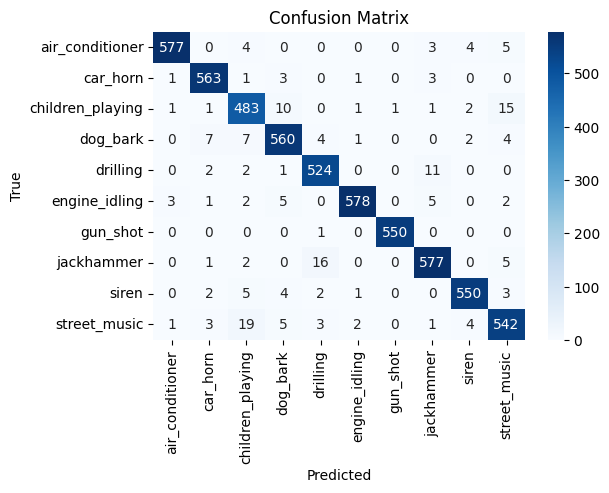

In [4]:
# Function to extract spectrogram
def extract_spectrogram(audio, sr):
    stft = np.abs(librosa.stft(audio))
    spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
    return spectrogram

# Function to extract MFCC
def extract_mfcc(audio, sr):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return mfcc

# Function to extract scalogram
def extract_scalogram(audio, sr):
    wavelet = librosa.cqt(audio, sr=sr)
    scalogram = librosa.amplitude_to_db(np.abs(wavelet), ref=np.max)
    return scalogram

# Function to combine features (spectrogram, scalogram, MFCC)
def extract_combined_features(audio_file):
    audio, sr = librosa.load(audio_file, sr=44100)
    spectrogram = extract_spectrogram(audio, sr)
    mfcc = extract_mfcc(audio, sr)
    scalogram = extract_scalogram(audio, sr)

    # Resize each feature to 128x128 for consistency
    spectrogram = np.resize(spectrogram, (128, 128))
    mfcc = np.resize(mfcc, (128, 128))
    scalogram = np.resize(scalogram, (128, 128))

    # Stack to create a 3-channel input
    combined_features = np.stack([spectrogram, mfcc, scalogram], axis=-1)
    return combined_features

# Load dataset without metadata, using folder names as labels
def load_data_from_folders(audio_path):
    X = []
    y = []
    class_labels = sorted(os.listdir(audio_path))  # Assuming folders represent classes

    for label in class_labels:
        label_folder = os.path.join(audio_path, label)
        if os.path.isdir(label_folder):
            for audio_file in os.listdir(label_folder):
                file_path = os.path.join(label_folder, audio_file)
                try:
                    features = extract_combined_features(file_path)
                    X.append(features)
                    y.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    return np.array(X), np.array(y)

# Define input shape and number of classes
input_shape = (128, 128, 3)
audio_path = '/content/drive/MyDrive/Urban sound 4sec(38k)'  # Root folder containing class subdirectories
num_classes = len(os.listdir(audio_path))  # Number of classes based on folder count

# Load data
X, y = load_data_from_folders(audio_path)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Define AlexNet-type CNN model
def build_alexnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Layer 1: Convolution + Max Pooling
    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='same')(inputs)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Layer 2: Convolution + Max Pooling
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Layer 3-5: Convolution layers
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and compile the model
model = build_alexnet_model(input_shape, num_classes)

# Callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=128,  # Adjust based on available GPU memory

    callbacks=[early_stopping, reduce_lr]
)

#################### evaluate result #####################

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report and confusion matrix for model evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()